# Optimized LSTM Model for Crowd & Saturation Forecasting (Toronto Tourism)
This notebook trains an optimized LSTM model to predict **Pedestrian_Count** and **Tourist_Saturation_Level** using historical crowd, weather, and event data.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional,Embedding
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

Loading Data, Changing Date to Datetime, Sort Values by Location_ID then Date  

In [2]:
df = pd.read_csv('pedes_count_data/Toronto_Tourism_Pedestrian_Data_Sorted.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['Location_ID', 'Date'], inplace=True)
dfc = df.copy()
dfc.head(3)

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,Pedestrian_Count,Weather_Temperature,Weather_Precipitation,Weather_Wind_Speed,Event_Flag,Holiday_Flag,Day_of_Week,Month,Season,Attraction_Score,Tourist_Saturation_Level
0,Canada,Toronto,TOR_01,CN Tower,Landmark,Indoor/Observation,43.6426,-79.3871,2018-01-01,21192,9.5,0.0,22.2,0,1,Monday,January,Winter,5,78.5
1,Canada,Toronto,TOR_01,CN Tower,Landmark,Indoor/Observation,43.6426,-79.3871,2018-01-02,14241,11.8,1.0,19.0,0,0,Tuesday,January,Winter,5,52.7
2,Canada,Toronto,TOR_01,CN Tower,Landmark,Indoor/Observation,43.6426,-79.3871,2018-01-03,13910,7.7,0.0,22.6,0,0,Wednesday,January,Winter,5,51.5


In [3]:
dfc.describe(include='all')

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,Pedestrian_Count,Weather_Temperature,Weather_Precipitation,Weather_Wind_Speed,Event_Flag,Holiday_Flag,Day_of_Week,Month,Season,Attraction_Score,Tourist_Saturation_Level
count,51408,51408,51408,51408,51408,51408,51408.000000,51408.000000,51408,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408,51408,51408,51408.000000,51408.000000
unique,1,1,18,18,17,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,12,4,NaN,NaN
top,Canada,Toronto,TOR_01,CN Tower,Intersection,Outdoor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday,January,Spring,NaN,NaN
freq,51408,51408,2856,2856,5712,39984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7344,4464,13248,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,43.650078,-79.387239,2021-11-28 12:00:00,21389.159917,10.768172,1.033053,14.831232,0.017838,0.029762,NaN,NaN,NaN,3.833333,72.852515
min,NaN,NaN,NaN,NaN,NaN,NaN,43.638700,-79.463700,2018-01-01 00:00:00,2875.000000,-16.000000,0.000000,0.900000,0.000000,0.000000,NaN,NaN,NaN,2.000000,26.600000
25%,NaN,NaN,NaN,NaN,NaN,NaN,43.646500,-79.387100,2019-12-15 18:00:00,11502.000000,1.400000,0.000000,11.400000,0.000000,0.000000,NaN,NaN,NaN,3.000000,60.900000
50%,NaN,NaN,NaN,NaN,NaN,NaN,43.648600,-79.382600,2021-11-28 12:00:00,17885.000000,10.700000,0.000000,14.800000,0.000000,0.000000,NaN,NaN,NaN,4.000000,71.400000
75%,NaN,NaN,NaN,NaN,NaN,NaN,43.654400,-79.380600,2023-11-12 06:00:00,28416.500000,20.200000,0.500000,18.400000,0.000000,0.000000,NaN,NaN,NaN,4.000000,85.200000
max,NaN,NaN,NaN,NaN,NaN,NaN,43.670800,-79.359600,2025-10-26 00:00:00,94500.000000,36.400000,20.400000,29.700000,1.000000,1.000000,NaN,NaN,NaN,5.000000,100.000000


Location Indexing & Cylidical Encoding

In [4]:
dfLocDex = dfc.copy()
dfLocDex['Location_Index'] = dfLocDex['Location_ID'].astype('category').cat.codes
dfCylEnc = dfLocDex.copy().drop(columns=['Month','Day_of_Week','Season'])

dfCylEnc['Month_Sin'] = np.sin(2 * np.pi * dfCylEnc['Date'].dt.month / 12)
dfCylEnc['Month_Cos'] = np.cos(2 * np.pi * dfCylEnc['Date'].dt.month / 12)
dfCylEnc['Day_Sin']   = np.sin(2 * np.pi * dfCylEnc['Date'].dt.dayofweek / 7)
dfCylEnc['Day_Cos']   = np.cos(2 * np.pi * dfCylEnc['Date'].dt.dayofweek / 7)
dfCylEnc.head(3)

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,Pedestrian_Count,Weather_Temperature,Weather_Precipitation,Weather_Wind_Speed,Event_Flag,Holiday_Flag,Attraction_Score,Tourist_Saturation_Level,Location_Index,Month_Sin,Month_Cos,Day_Sin,Day_Cos
0,Canada,Toronto,TOR_01,CN Tower,Landmark,Indoor/Observation,43.6426,-79.3871,2018-01-01,21192,9.5,0.0,22.2,0,1,5,78.5,0,0.5,0.866025,0.000000,1.000000
1,Canada,Toronto,TOR_01,CN Tower,Landmark,Indoor/Observation,43.6426,-79.3871,2018-01-02,14241,11.8,1.0,19.0,0,0,5,52.7,0,0.5,0.866025,0.781831,0.623490
2,Canada,Toronto,TOR_01,CN Tower,Landmark,Indoor/Observation,43.6426,-79.3871,2018-01-03,13910,7.7,0.0,22.6,0,0,5,51.5,0,0.5,0.866025,0.974928,-0.222521


Applying Integer Encoding on Type_of_Attraction and Attraction_Category to then drop them after

In [5]:
dfle = dfCylEnc.copy()
dfle["Type_of_Attraction_Encoded"] = dfle["Type_of_Attraction"].astype("category").cat.codes
dfle["Attraction_Category_Encoded"] = dfle["Attraction_Category"].astype("category").cat.codes
dfle = dfle.drop(columns=['Type_of_Attraction','Attraction_Category'])
dfle.head(3)

,Country,City,Location_ID,Location_Name,Latitude,Longitude,Date,Pedestrian_Count,Weather_Temperature,Weather_Precipitation,Weather_Wind_Speed,Event_Flag,Holiday_Flag,Attraction_Score,Tourist_Saturation_Level,Location_Index,Month_Sin,Month_Cos,Day_Sin,Day_Cos,Type_of_Attraction_Encoded,Attraction_Category_Encoded
0,Canada,Toronto,TOR_01,CN Tower,43.6426,-79.3871,2018-01-01,21192,9.5,0.0,22.2,0,1,5,78.5,0,0.5,0.866025,0.000000,1.000000,9,1
1,Canada,Toronto,TOR_01,CN Tower,43.6426,-79.3871,2018-01-02,14241,11.8,1.0,19.0,0,0,5,52.7,0,0.5,0.866025,0.781831,0.623490,9,1
2,Canada,Toronto,TOR_01,CN Tower,43.6426,-79.3871,2018-01-03,13910,7.7,0.0,22.6,0,0,5,51.5,0,0.5,0.866025,0.974928,-0.222521,9,1


Feature Selection

In [5]:
dfF = dfCylEnc.copy().drop(columns=['Country','City','Latitude','Longitude'])
dfF.head(3)

,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Date,Pedestrian_Count,Weather_Temperature,Weather_Precipitation,Weather_Wind_Speed,Event_Flag,Holiday_Flag,Attraction_Score,Tourist_Saturation_Level,Location_Index,Month_Sin,Month_Cos,Day_Sin,Day_Cos
0,TOR_01,CN Tower,Landmark,Indoor/Observation,2018-01-01,21192,9.5,0.0,22.2,0,1,5,78.5,0,0.5,0.866025,0.000000,1.000000
1,TOR_01,CN Tower,Landmark,Indoor/Observation,2018-01-02,14241,11.8,1.0,19.0,0,0,5,52.7,0,0.5,0.866025,0.781831,0.623490
2,TOR_01,CN Tower,Landmark,Indoor/Observation,2018-01-03,13910,7.7,0.0,22.6,0,0,5,51.5,0,0.5,0.866025,0.974928,-0.222521


In [6]:
dfF.describe(include='all')

,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Date,Pedestrian_Count,Weather_Temperature,Weather_Precipitation,Weather_Wind_Speed,Event_Flag,Holiday_Flag,Attraction_Score,Tourist_Saturation_Level,Location_Index,Month_Sin,Month_Cos,Day_Sin,Day_Cos
count,51408,51408,51408,51408,51408,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,5.140800e+04,5.140800e+04,5.140800e+04,5.140800e+04
unique,18,18,17,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,TOR_01,CN Tower,Intersection,Outdoor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2856,2856,5712,39984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2021-11-28 12:00:00,21389.159917,10.768172,1.033053,14.831232,0.017838,0.029762,3.833333,72.852515,8.500000,1.873027e-03,-2.290230e-02,1.006820e-17,-3.082225e-17
min,NaN,NaN,NaN,NaN,2018-01-01 00:00:00,2875.000000,-16.000000,0.000000,0.900000,0.000000,0.000000,2.000000,26.600000,0.000000,-1.000000e+00,-1.000000e+00,-9.749279e-01,-9.009689e-01
25%,NaN,NaN,NaN,NaN,2019-12-15 18:00:00,11502.000000,1.400000,0.000000,11.400000,0.000000,0.000000,3.000000,60.900000,4.000000,-8.660254e-01,-8.660254e-01,-7.818315e-01,-9.009689e-01
50%,NaN,NaN,NaN,NaN,2021-11-28 12:00:00,17885.000000,10.700000,0.000000,14.800000,0.000000,0.000000,4.000000,71.400000,8.500000,1.224647e-16,-1.836970e-16,0.000000e+00,-2.225209e-01
75%,NaN,NaN,NaN,NaN,2023-11-12 06:00:00,28416.500000,20.200000,0.500000,18.400000,0.000000,0.000000,4.000000,85.200000,13.000000,5.915064e-01,5.000000e-01,7.818315e-01,6.234898e-01
max,NaN,NaN,NaN,NaN,2025-10-26 00:00:00,94500.000000,36.400000,20.400000,29.700000,1.000000,1.000000,5.000000,100.000000,17.000000,1.000000e+00,1.000000e+00,9.749279e-01,1.000000e+00


Scaling Data

In [7]:
features = [
'Weather_Temperature', 'Weather_Wind_Speed','Weather_Precipitation',
'Event_Flag', 'Holiday_Flag', 'Attraction_Score',
'Month_Sin', 'Month_Cos', 'Day_Sin', 'Day_Cos'
] # ,'Type_of_Attraction_Encoded','Attraction_Category_Encoded',
targets = ['Pedestrian_Count', 'Tourist_Saturation_Level']
scaler = MinMaxScaler()
dfFScl = dfF.copy()
dfFScl[features + targets] = scaler.fit_transform(dfFScl[features + targets])
dfFScl.describe(include='all')

,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Date,Pedestrian_Count,Weather_Temperature,Weather_Precipitation,Weather_Wind_Speed,Event_Flag,Holiday_Flag,Attraction_Score,Tourist_Saturation_Level,Location_Index,Month_Sin,Month_Cos,Day_Sin,Day_Cos
count,51408,51408,51408,51408,51408,51408.000000,51408.000000,51408.00000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,5.140800e+04
unique,18,18,17,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,TOR_01,CN Tower,Intersection,Outdoor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2856,2856,5712,39984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2021-11-28 12:00:00,0.202065,0.510843,0.05064,0.483723,0.017838,0.029762,0.611111,0.630143,8.500000,0.500937,0.488549,0.500000,4.739525e-01
min,NaN,NaN,NaN,NaN,2018-01-01 00:00:00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,NaN,NaN,NaN,NaN,2019-12-15 18:00:00,0.094156,0.332061,0.00000,0.364583,0.000000,0.000000,0.333333,0.467302,4.000000,0.066987,0.066987,0.099031,5.551115e-17
50%,NaN,NaN,NaN,NaN,2021-11-28 12:00:00,0.163820,0.509542,0.00000,0.482639,0.000000,0.000000,0.666667,0.610354,8.500000,0.500000,0.500000,0.500000,3.568959e-01
75%,NaN,NaN,NaN,NaN,2023-11-12 06:00:00,0.278761,0.690840,0.02451,0.607639,0.000000,0.000000,0.666667,0.798365,13.000000,0.795753,0.750000,0.900969,8.019377e-01
max,NaN,NaN,NaN,NaN,2025-10-26 00:00:00,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,1.000000,1.000000,1.000000,1.000000e+00


Creating Sequences for the LSTM model

In [8]:
def create_sequences(df, features, targets, seq_len=30):
    X,y = [], []
    for loc in df['Location_ID'].unique():
        sub = df[df['Location_ID'] == loc].sort_values('Date')
        feat_values = sub[features].values
        target_values = sub[targets].values
        for i in range(seq_len, len(sub)):
            X.append(feat_values[i-seq_len:i])
            y.append(target_values[i])
    return np.array(X), np.array(y)
SEQ_LEN = 30
X, y = create_sequences(dfFScl, features, targets, SEQ_LEN)

Splitting data for train, loc, and test

In [9]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print('X_train:', X_train.shape, 'y_train:', y_train.shape)

X_train: (40694, 30, 10) y_train: (40694, 2)


Creating the RNN/LSTM Model 

In [ ]:
model = Sequential([
    Bidirectional(LSTM(96, return_sequences=True, input_shape=(SEQ_LEN, len(features)))),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')])
optimizer = Adam(learning_rate=0.001) #0.001,0.01
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

c:\Users\athar\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=64, callbacks=[early_stop, lr_scheduler], verbose=1)

Epoch 1/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - loss: 0.0225 - mae: 0.1151 - val_loss: 0.0235 - val_mae: 0.1259 - learning_rate: 0.0010
Epoch 2/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - loss: 0.0166 - mae: 0.1017 - val_loss: 0.0225 - val_mae: 0.1227 - learning_rate: 0.0010
Epoch 3/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - loss: 0.0152 - mae: 0.0975 - val_loss: 0.0211 - val_mae: 0.1196 - learning_rate: 0.0010
Epoch 4/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0145 - mae: 0.0953 - val_loss: 0.0240 - val_mae: 0.1267 - learning_rate: 0.0010
Epoch 5/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0142 - mae: 0.0942 - val_loss: 0.0249 - val_mae: 0.1313 - learning_rate: 0.0010
Epoch 6/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.0140 - mae: 0.0937 - val_loss: 0.0206 - val_mae: 0.1177 - learning_rate: 0.0010
Epoch 7/40
509/509 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0137 - mae: 0.0926 - val_loss: 0.0226 - val_mae: 0.1241 - learning_rate:

Eval the model

In [21]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'✅ RMSE: {rmse:.4f}') # 0.1017
print(f'✅ MAE : {mae:.4f}') # 0.0773
print(f'✅ R²   : {r2:.4f}') # 0.6500

318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
✅ RMSE: 0.1063
✅ MAE : 0.0825
✅ R²   : 0.5735


- 0: epochs=40, batch_size=64, alpha=0.001, Bidire(LSTM(96)), RMSE: 0.1017, MAE: 0.0773, R2: 0.6500 
- 1: epochs=40, batch_size=64, alpha=0.001, Bidire(LSTM(80)), RMSE: 0.1063, MAE: 0.0825, R2: 0.5735 

Plotting the Actual to Predicited 

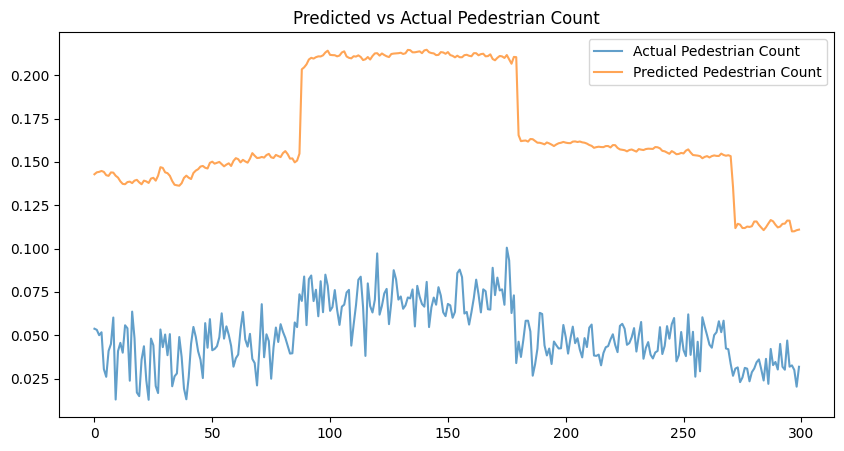

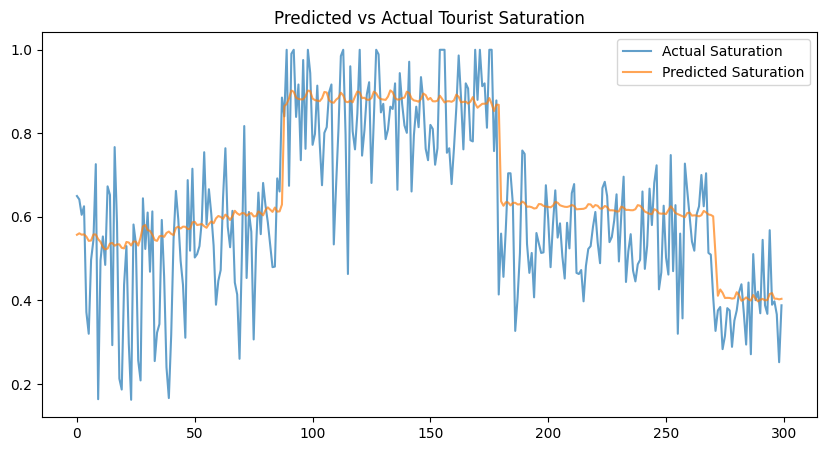

In [22]:
plt.figure(figsize=(10,5))
plt.plot(y_test[:300,0], label='Actual Pedestrian Count', alpha=0.7)
plt.plot(y_pred[:300,0], label='Predicted Pedestrian Count', alpha=0.7)
plt.legend()
plt.title('Predicted vs Actual Pedestrian Count')
plt.show()
plt.figure(figsize=(10,5))
plt.plot(y_test[:300,1], label='Actual Saturation', alpha=0.7)
plt.plot(y_pred[:300,1], label='Predicted Saturation', alpha=0.7)
plt.legend()
plt.title('Predicted vs Actual Tourist Saturation')
plt.show()

In [23]:
model.save('Output Charts/1optimized_lstm_tourism_model.h5')
import joblib
joblib.dump(scaler, 'Output Charts/1scaler.pkl')
print('Model and scaler saved successfully.')

Model and scaler saved successfully.
